In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike

In [2]:
cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_3_alone_comp_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list

In [3]:
# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df3.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

In [4]:
# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

In [5]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'recordings' / 'Cohort3' / 'alone_comp'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
20240320_142408_alone_comp_subj_3-1_t6b6_merged.rec
<class 'numpy.ndarray'>
20240320_142408_alone_comp_subj_3-3_t5b5_merged.rec
<class 'numpy.ndarray'>
20240320_171038_alone_comp_subj_4-2_t6b6_merged.rec
<class 'numpy.ndarray'>
20240320_171038_alone_comp_subj_4-3_t5b5_merged.rec
<class 'numpy.ndarray'>
20240322_120625_alone_comp_subj_3-3_t6b6_merged.rec
<class 'numpy.ndarray'>
20240322_120625_alone_comp_subj_3-4_t5b5_merged.rec
<class 'numpy.ndarray'>
20240322_160946_alone_comp_subj_4-3_t6b6_merged.rec
<class 'numpy.ndarray'>
20240323_122227_alone_comp_subj_5-2_t6b6_merged.rec
<class 'numpy.ndarray'>
20240323_144517_alone_comp_subj_3-4_t6b6_merged.rec
<class 'numpy.ndarray'>
20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec
Please assign event dictionaries to each recording
as recording.event_dict
event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]
Please assign subjects to each recording as recording.subject


In [6]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject

In [7]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=300, ignore_freq = 0.5)

All set to analyze


Wilcoxon can't be done on 20240320_171038_alone_comp_subj_4-2_t6b6_merged.rec win, because <6 samples
Wilcoxon can't be done on 20240322_120625_alone_comp_subj_3-3_t6b6_merged.rec win, because <6 samples
Wilcoxon can't be done on 20240323_122227_alone_comp_subj_5-2_t6b6_merged.rec win, because <6 samples


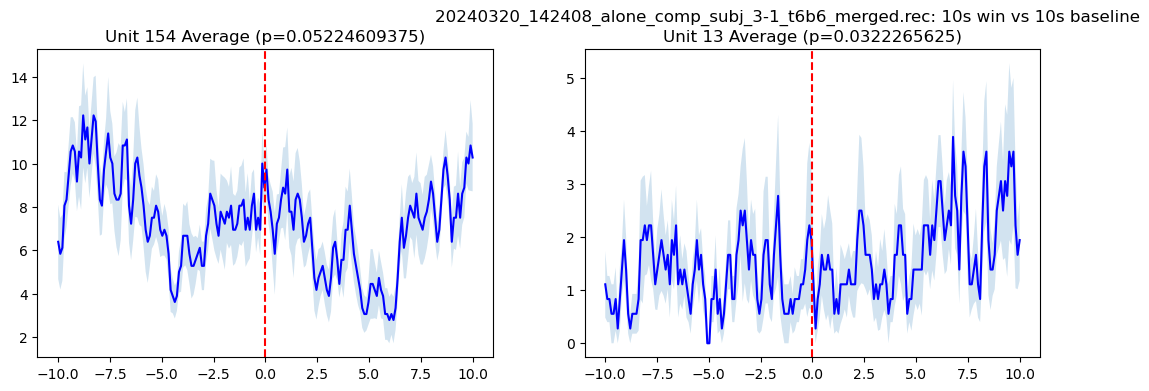

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

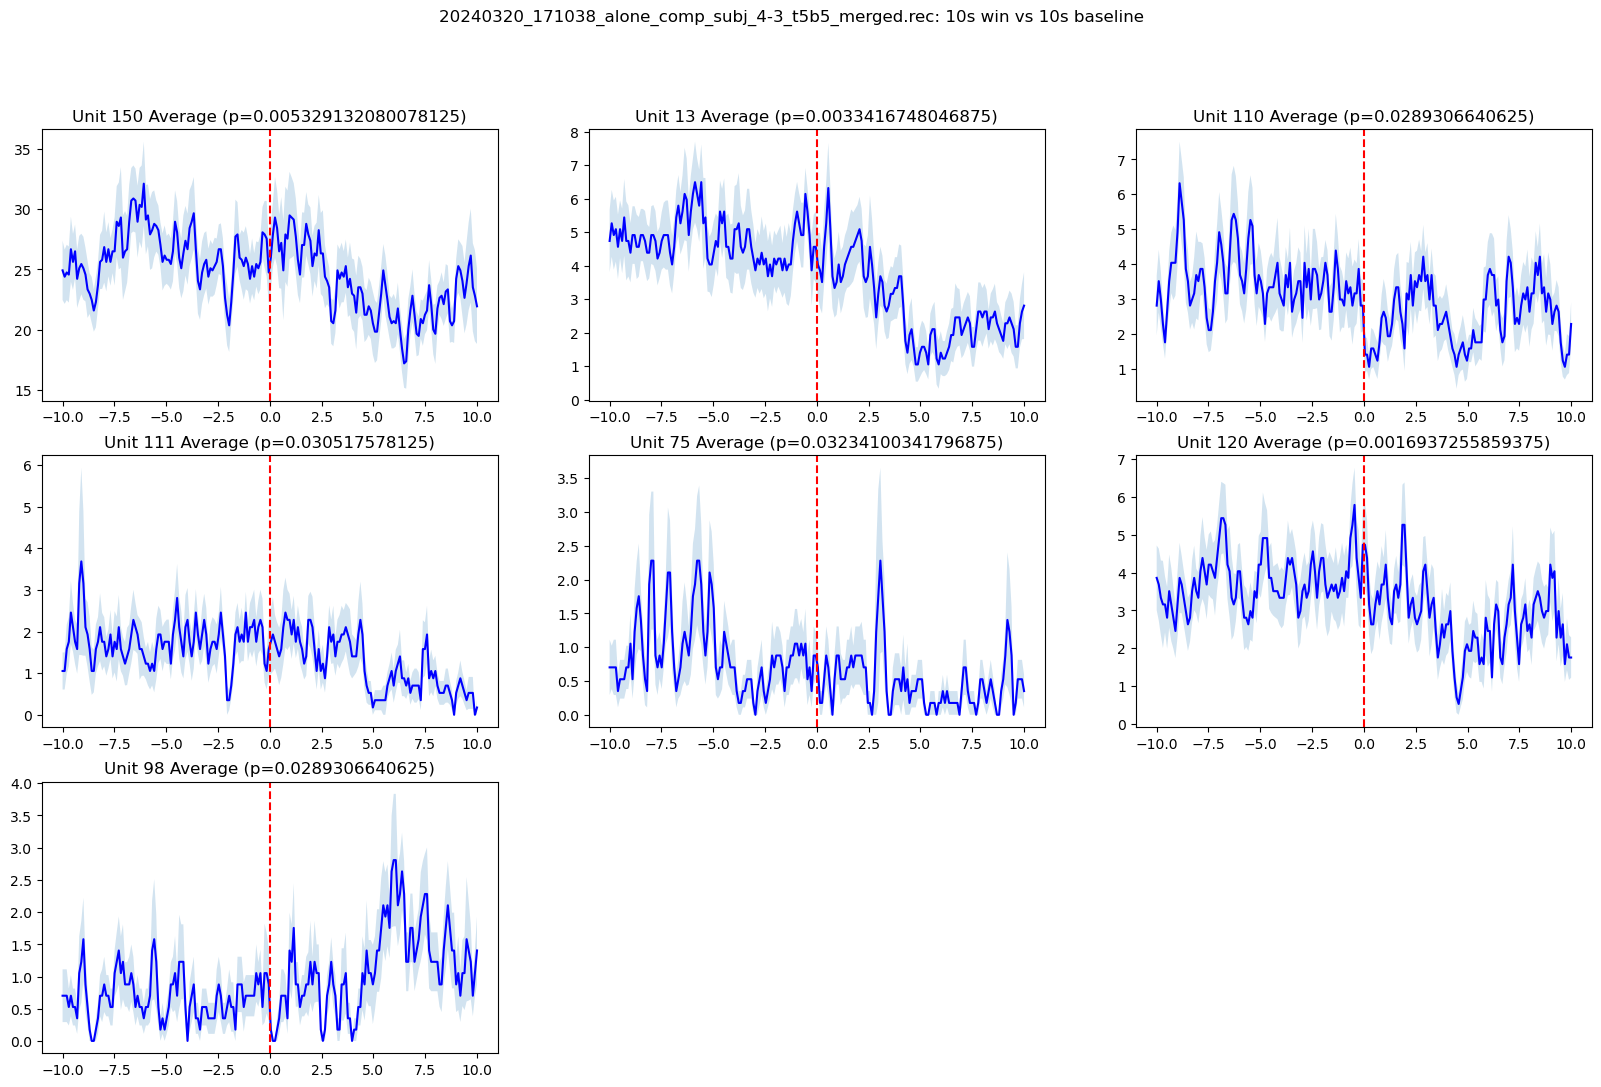

<Figure size 2000x0 with 0 Axes>

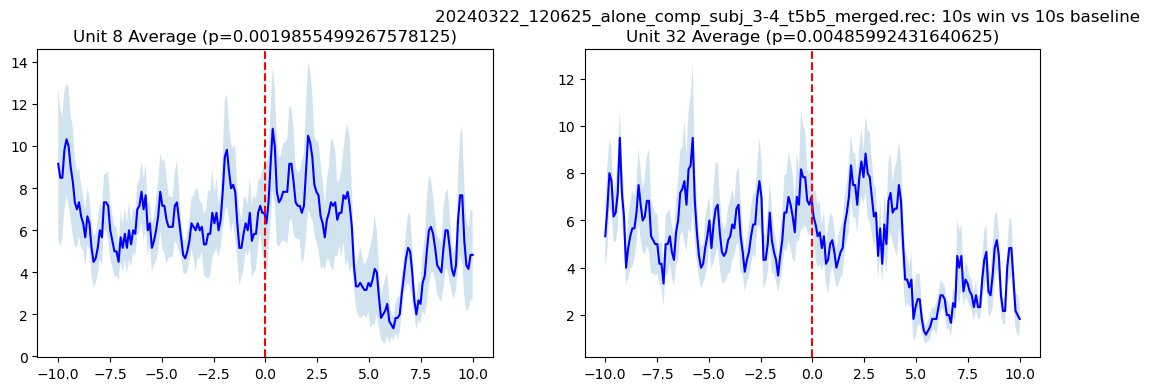

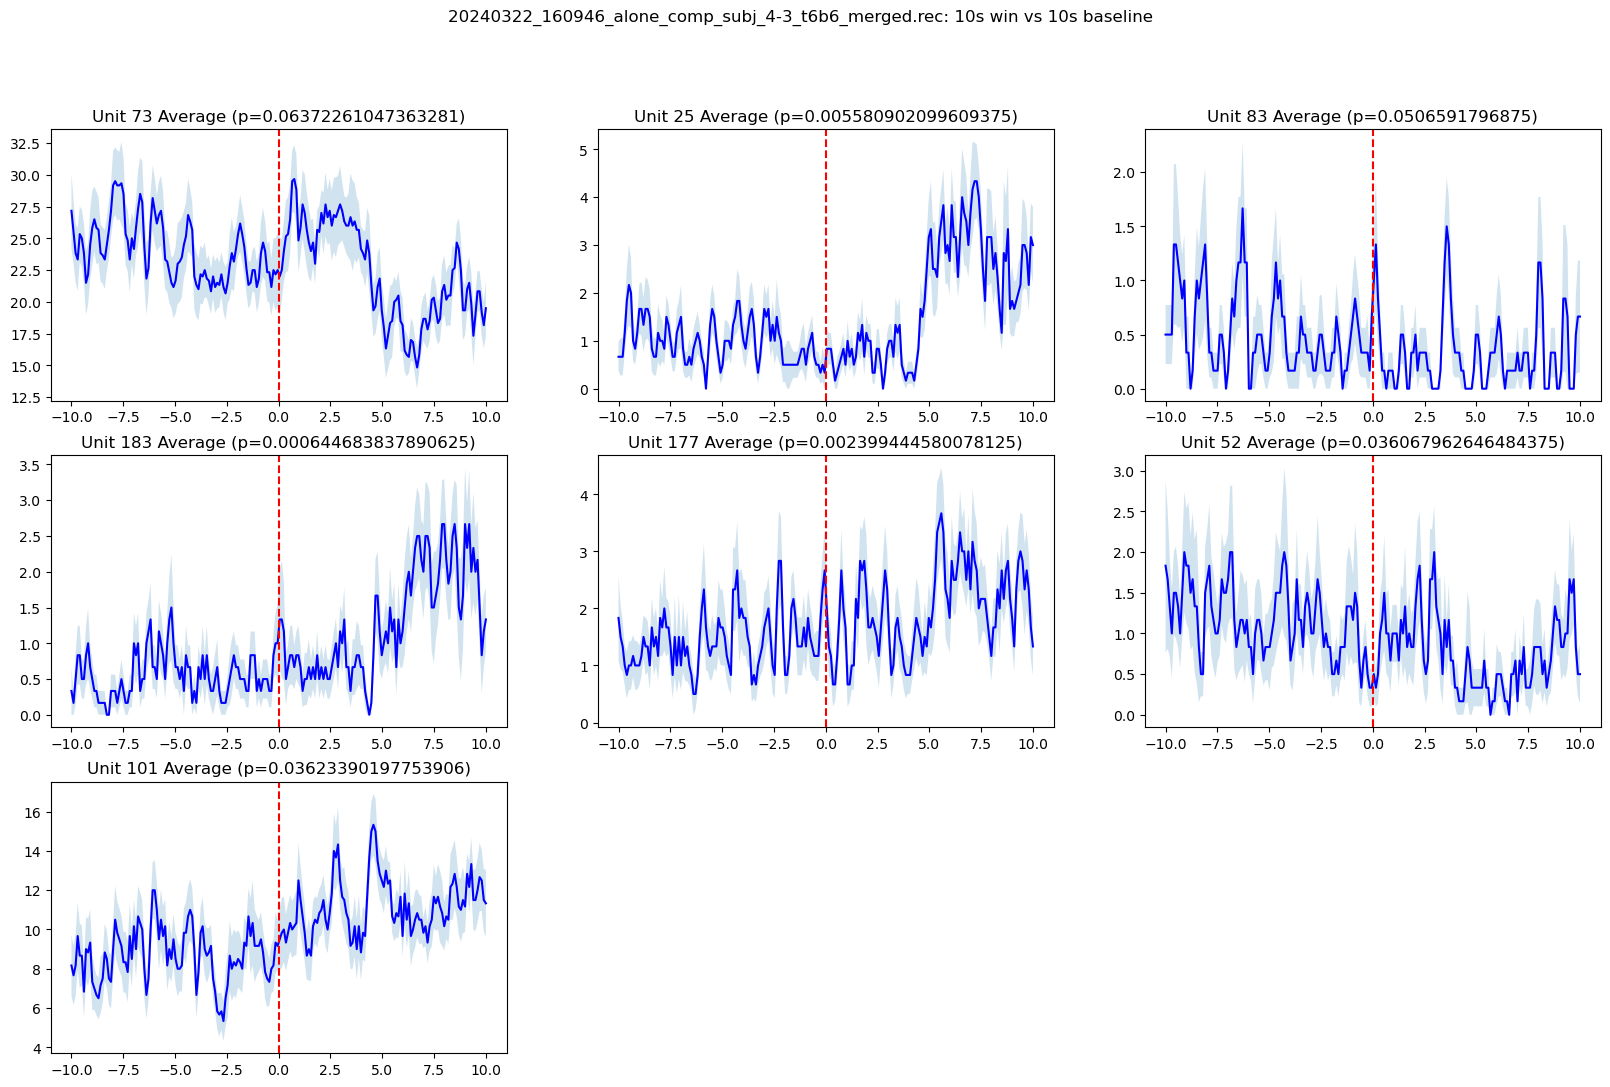

<Figure size 2000x0 with 0 Axes>

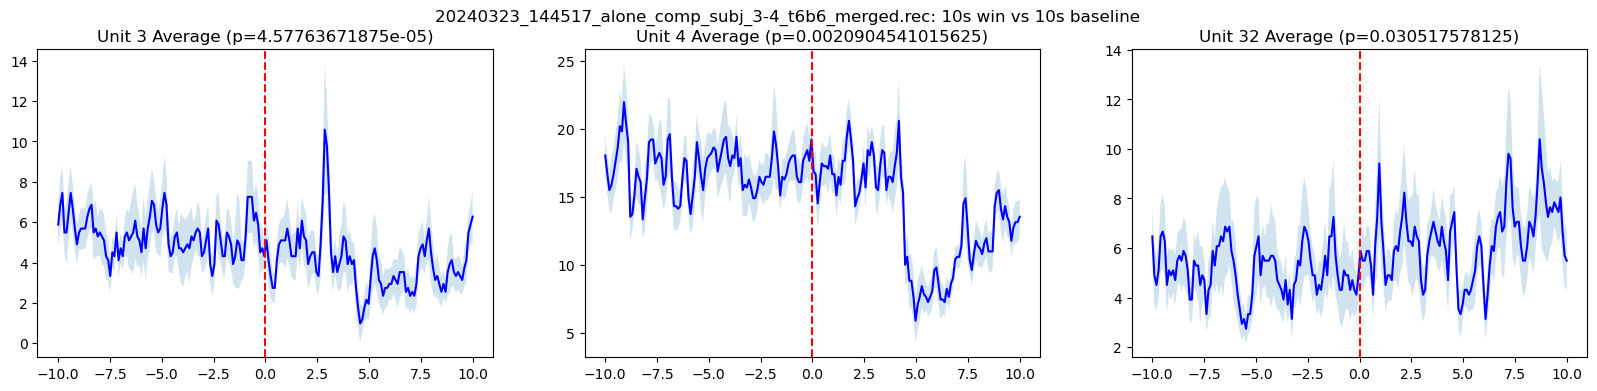

<Figure size 2000x0 with 0 Axes>

In [8]:
win_df = spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10)

Wilcoxon can't be done on 20240320_171038_alone_comp_subj_4-3_t5b5_merged.rec lose, because <6 samples
Wilcoxon can't be done on 20240322_120625_alone_comp_subj_3-4_t5b5_merged.rec lose, because <6 samples
Wilcoxon can't be done on 20240322_160946_alone_comp_subj_4-3_t6b6_merged.rec lose, because <6 samples
Wilcoxon can't be done on 20240323_144517_alone_comp_subj_3-4_t6b6_merged.rec lose, because <6 samples


<Figure size 2000x0 with 0 Axes>

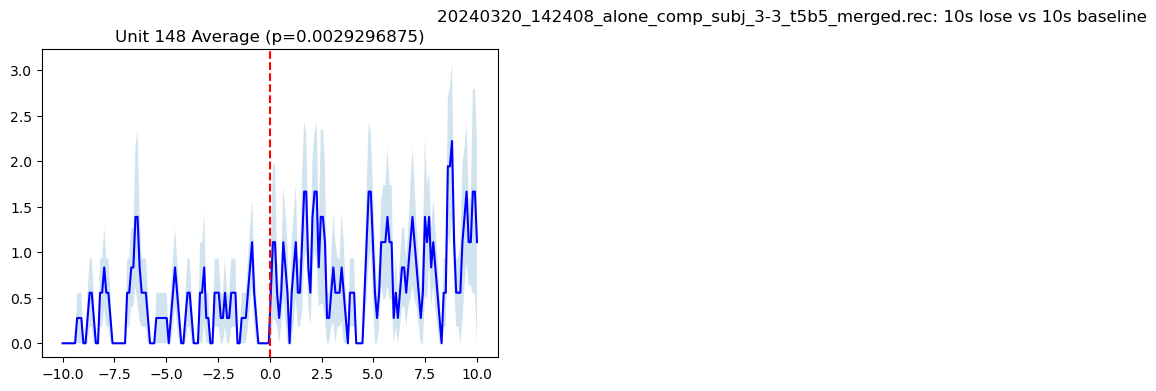

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

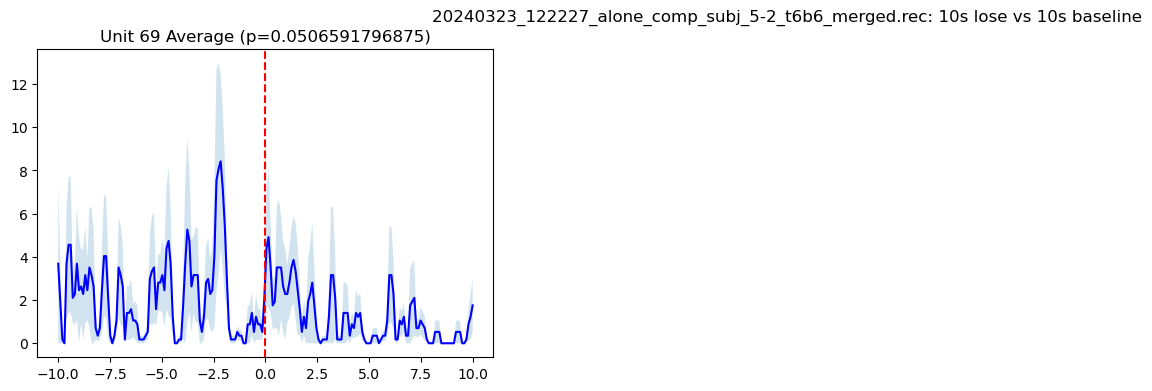

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

In [9]:
lose_df = spike_analysis.wilcox_baseline_v_event_collection('lose', 10, 10)

In [10]:
lose_df

original unit id  Wilcoxon Stat   p value event1 vs event2  \
0                 18           16.0  0.843750  not significant   
1                  9           14.0  0.640625  not significant   
2                 20           17.0  0.945312  not significant   
3                154           17.0  0.945312  not significant   
4                123            9.0  0.250000  not significant   
5                115           11.0  0.382812  not significant   
6                117            7.5  0.687500  not significant   
7                150           11.0  0.382812  not significant   
8                 13           12.0  0.460938  not significant   
9                190           14.0  1.000000  not significant   
10               124           34.0  0.733398  not significant   
11               148            2.0  0.002930        increases   
12                45           18.0  0.109863  not significant   
13               146           38.5  1.000000  not significant   
14               109           20.0  0.278320  not significant   
15                60           24.0  0.464844  not significant   
16                67           36.0  0.850098  not significant   
17                 9           51.0  0.403748  not significant   
18                56           51.5  0.154045  not significant   
19                42           52.5  0.095512  not significant   
20                33           42.0  0.192810  not significant   
21                 0            NaN       NaN              NaN   
22                15          101.0  0.898317  not significant   
23                 3           27.5  0.243896  not significant   
24               101           87.0  0.521673  not significant   
25                47           92.0  0.647655  not significant   
26                89           60.5  0.105398  not significant   
27                72           73.0  0.245487  not significant   
28               103           93.0  0.952984  not significant   
29                18           73.0  0.889969  not significant   
30                60           85.0  1.000000  not significant   
31                76           65.0  0.392738  not significant   
32                 0            NaN       NaN              NaN   
33                 0            NaN       NaN              NaN   
34                68           81.0  0.865044  not significant   
35                32           73.0  0.395462  not significant   
36                72           76.5  0.489967  not significant   
37                52           76.0  0.701881  not significant   
38                69           30.0  0.050659  not significant   
39                 0            NaN       NaN              NaN   
40                42           20.0  0.492188  not significant   
41                27           20.0  0.492188  not significant   
42                54           11.0  0.105469  not significant   
43                18           21.0  0.556641  not significant   
44                 0           25.0  0.845703  not significant   
45                49           20.0  0.820312  not significant   
46                81           23.0  0.695312  not significant   
47                75            7.0  0.148438  not significant   
48                68           19.5  0.492188  not significant   
49                 4           20.0  0.492188  not significant   
50                24           24.0  0.769531  not significant   

                                            Recording Subject  \
0   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
1   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
2   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
3   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
4   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
5   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
6   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
7   20240320_142408_alone_comp_subj_3-1_t6b6_merge.

In [11]:
lose_df['event1 vs event2'].value_counts()

event1 vs event2
not significant    46
increases           1
Name: count, dtype: int64

In [12]:
win_df['event1 vs event2'].value_counts()

event1 vs event2
not significant    64
increases          18
Name: count, dtype: int64

In [13]:
win_df

original unit id  Wilcoxon Stat   p value event1 vs event2  \
0                 18           26.0  0.339355  not significant   
1                  9           21.5  0.203613  not significant   
2                 20           19.0  0.129395  not significant   
3                154           14.0  0.052246  not significant   
4                123           18.0  0.109863  not significant   
..               ...            ...       ...              ...   
80                81            6.0  0.218750  not significant   
81                75           10.0  1.000000  not significant   
82                68           14.0  1.000000  not significant   
83                 4            3.0  0.078125  not significant   
84                24            6.0  0.218750  not significant   

                                            Recording Subject  \
0   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
1   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
2   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
3   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
4   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
..                                                ...     ...   
80  20240323_165815_alone_comp_subj_4-2_t5b5_merge...     4-2   
81  20240323_165815_alone_comp_subj_4-2_t5b5_merge...     4-2   
82  20240323_165815_alone_comp_subj_4-2_t5b5_merge...     4-2   
83  20240323_165815_alone_comp_subj_4-2_t5b5_merge...     4-2   
84  20240323_165815_alone_comp_subj_4-2_t5b5_merge...     4-2   

                      Event  
0   10s win vs 10s baseline  
1   10s win vs 10s baseline  
2   10s win vs 10s baseline  
3   10s win vs 10s baseline  
4   10s win vs 10s baseline  
..                      ...  
80  10s win vs 10s baseline  
81  10s win vs 10s baseline  
82  10s win vs 10s baseline  
83  10s win vs 10s baseline  
84  10s win vs 10s baseline  

[85 rows x 7 columns]

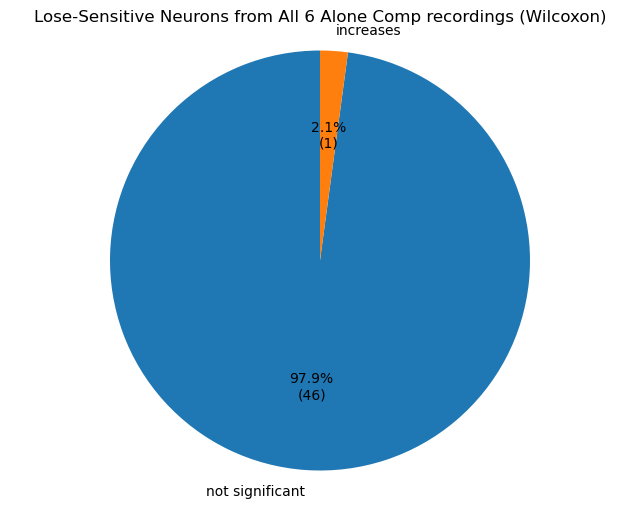

In [14]:
# Calculate value counts
value_counts = lose_df['event1 vs event2'].value_counts()

# Function to calculate the label with both count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:d})'
    return my_autopct

# Plotting the pie chart
plt.figure(figsize=(8, 6))  # Adjusts the figure size
plt.pie(value_counts, labels=value_counts.index, autopct=make_autopct(value_counts), startangle=90)
plt.title('Lose-Sensitive Neurons from All 6 Alone Comp recordings (Wilcoxon)')
plt.axis('equal')  # Ensures that pie is drawn as a circle.

# Display the plot
plt.show()

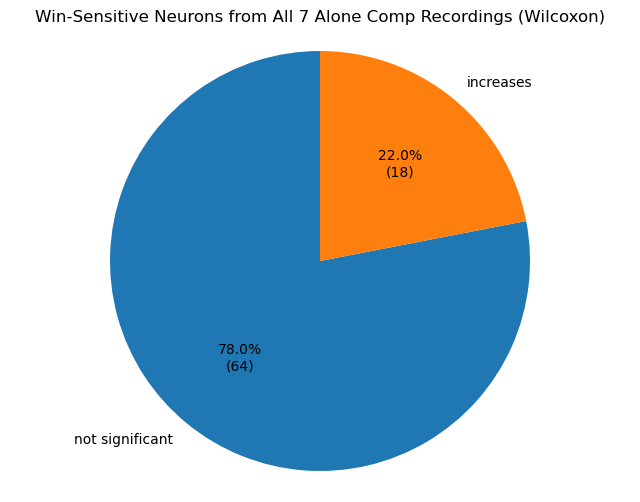

In [15]:
value_counts = win_df['event1 vs event2'].value_counts()

# Function to calculate the label with both count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:d})'
    return my_autopct

# Plotting the pie chart
plt.figure(figsize=(8, 6))  # Adjusts the figure size
plt.pie(value_counts, labels=value_counts.index, autopct=make_autopct(value_counts), startangle=90)
plt.title('Win-Sensitive Neurons from All 7 Alone Comp Recordings (Wilcoxon)')
plt.axis('equal')  # Ensures that pie is drawn as a circle.

# Display the plot
plt.show()

In [16]:
win_sigs = win_df[win_df['event1 vs event2']!='not significant']

In [17]:
win_sigs = win_sigs.dropna()

In [18]:
win_sigs

original unit id  Wilcoxon Stat   p value event1 vs event2  \
8                 13            9.0  0.032227        increases   
20               150           28.0  0.005329        increases   
21                13           25.0  0.003342        increases   
30               110           40.5  0.028931        increases   
31               111           31.0  0.030518        increases   
32                75           42.0  0.032341        increases   
33               120           21.0  0.001694        increases   
38                98           41.0  0.028931        increases   
41                 8           26.0  0.001986        increases   
42                32           32.0  0.004860        increases   
49                25           32.5  0.005581        increases   
59               183           15.5  0.000645        increases   
63               177           23.0  0.002399        increases   
64                52           42.5  0.036068        increases   
66               101           49.0  0.036234        increases   
69                 3            2.0  0.000046        increases   
70                 4           15.0  0.002090        increases   
72                32           31.0  0.030518        increases   

                                            Recording Subject  \
8   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1   
20  20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3   
21  20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3   
30  20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3   
31  20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3   
32  20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3   
33  20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3   
38  20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3   
41  20240322_120625_alone_comp_subj_3-4_t5b5_merge...     3-4   
42  20240322_120625_alone_comp_subj_3-4_t5b5_merge...     3-4   
49  20240322_160946_alone_comp_subj_4-3_t6b6_merge...     4-3   
59  20240322_160946_alone_comp_subj_4-3_t6b6_merge...     4-3   
63  20240322_160946_alone_comp_subj_4-3_t6b6_merge...     4-3   
64  20240322_160946_alone_comp_subj_4-3_t6b6_merge...     4-3   
66  20240322_160946_alone_comp_subj_4-3_t6b6_merge...     4-3   
69  20240323_144517_alone_comp_subj_3-4_t6b6_merge...     3-4   
70  20240323_144517_alone_comp_subj_3-4_t6b6_merge...     3-4   
72  20240323_144517_alone_comp_subj_3-4_t6b6_merge...     3-4   

                      Event  
8   10s win vs 10s baseline  
20  10s win vs 10s baseline  
21  10s win vs 10s baseline  
30  10s win vs 10s baseline  
31  10s win vs 10s baseline  
32  10s win vs 10s baseline  
33  10s win vs 10s baseline  
38  10s win vs 10s baseline  
41  10s win vs 10s baseline  
42  10s win vs 10s baseline  
49  10s win vs 10s baseline  
59  10s win vs 10s baseline  
63  10s win vs 10s baseline  
64  10s win vs 10s baseline  
66  10s win vs 10s baseline  
69  10s win vs 10s baseline  
70  10s win vs 10s baseline  
72  10s win vs 10s baseline

In [19]:
import pickle

# Load the umap_df DataFrame from the pickle file
with open(r"waveform_id\umap_df_detail.pkl", "rb") as input_file:
    umap_df = pickle.load(input_file)

# Create a new DataFrame umap_rec from the entire umap_df
umap_rec = umap_df.copy()

# Split the recording_name into 'session' and 'subject'
umap_rec[['session', 'subject']] = umap_rec['recording_name'].str.extract(r'^(.*)_subj_([^_]+)')

# Replace any '.' with '-' in the 'subject' column
umap_rec['subject'] = umap_rec['subject'].str.replace('.', '-')

# Merge umap_rec with win_sigs based on recording_name, subject, and unit_id
umap_win = umap_rec.merge(win_sigs, how='inner', 
                          left_on=['recording_name', 'subject', 'unit_id'], 
                          right_on=['Recording', 'Subject', 'original unit id'])

# Drop the specified columns
columns_to_drop = ['x', 'y', 'waveform', 'Wilcoxon Stat', 'p value', 'recording_name', 'subject', 'Event']
umap_win_read = umap_win.drop(columns=columns_to_drop)

# Display the resulting DataFrame
umap_win_read

C:\Users\short\AppData\Local\Temp\ipykernel_19548\2010669331.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  umap_df = pickle.load(input_file)


cluster_id                     cluster_color  firing_rate  unit_id  \
0            4  [0.64362, 0.98999, 0.23356, 1.0]     7.743032      8.0   
1            6   [0.9836, 0.49291, 0.12849, 1.0]     5.968627     32.0   
2            8   [0.4796, 0.01583, 0.01055, 1.0]     1.968731     13.0   
3            6   [0.9836, 0.49291, 0.12849, 1.0]     7.247003      3.0   
4            4  [0.64362, 0.98999, 0.23356, 1.0]    14.841268      4.0   
5            8   [0.4796, 0.01583, 0.01055, 1.0]     3.859188     32.0   
6            5  [0.93301, 0.81236, 0.22667, 1.0]     3.987631     13.0   
7            3  [0.19659, 0.94901, 0.59466, 1.0]     0.669420     75.0   
8            8   [0.4796, 0.01583, 0.01055, 1.0]     0.728441     98.0   
9            4  [0.64362, 0.98999, 0.23356, 1.0]     2.533234    110.0   
10           4  [0.64362, 0.98999, 0.23356, 1.0]     1.295662    111.0   
11           6   [0.9836, 0.49291, 0.12849, 1.0]     3.154195    120.0   
12           5  [0.93301, 0.81236, 0.22667, 1.0]    26.271396    150.0   
13           6   [0.9836, 0.49291, 0.12849, 1.0]     1.656807     25.0   
14           7  [0.81608, 0.18462, 0.01809, 1.0]     0.790955     52.0   
15           1  [0.27628, 0.42118, 0.89123, 1.0]     6.106089    101.0   
16           7  [0.81608, 0.18462, 0.01809, 1.0]     1.227799    177.0   
17           8   [0.4796, 0.01583, 0.01055, 1.0]     0.974593    183.0   

                       session  original unit id event1 vs event2  \
0   20240322_120625_alone_comp                 8        increases   
1   20240322_120625_alone_comp                32        increases   
2   20240320_142408_alone_comp                13        increases   
3   20240323_144517_alone_comp                 3        increases   
4   20240323_144517_alone_comp                 4        increases   
5   20240323_144517_alone_comp                32        increases   
6   20240320_171038_alone_comp                13        increases   
7   20240320_171038_alone_comp                75        increases   
8   20240320_171038_alone_comp                98        increases   
9   20240320_171038_alone_comp               110        increases   
10  20240320_171038_alone_comp               111        increases   
11  20240320_171038_alone_comp               120        increases   
12  20240320_171038_alone_comp               150        increases   
13  20240322_160946_alone_comp                25        increases   
14  20240322_160946_alone_comp                52        increases   
15  20240322_160946_alone_comp               101        increases   
16  20240322_160946_alone_comp               177        increases   
17  20240322_160946_alone_comp               183        increases   

                                            Recording Subject  
0   20240322_120625_alone_comp_subj_3-4_t5b5_merge...     3-4  
1   20240322_120625_alone_comp_subj_3-4_t5b5_merge...     3-4  
2   20240320_142408_alone_comp_subj_3-1_t6b6_merge...     3-1  
3   20240323_144517_alone_comp_subj_3-4_t6b6_merge...     3-4  
4   20240323_144517_alone_comp_subj_3-4_t6b6_merge...     3-4  
5   20240323_144517_alone_comp_subj_3-4_t6b6_merge...     3-4  
6   20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3  
7   20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3  
8   20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3  
9   20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3  
10  20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3  
11  20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3  
12  20240320_171038_alone_comp_subj_4-3_t5b5_merge...     4-3  
13  20240322_160946_alone_comp_subj_4-3_t6b6_merge...     4-3  
14  20240322_160946_alone_comp_subj_4-3_t6b6_merge...     4-3  
15  20240322_160946_alone_comp_subj_4-3_t6b6_merge...     4-3  
16  20240322_160946_alone_comp_subj_4-3_t6b6_merge...     4-3  
17  20240322_160946_alone_comp_subj_4-3_t6b6_merge...     4-3

In [20]:
# For umap_win
cluster_counts_win = umap_win_read['cluster_id'].value_counts()
total_clusters_win = cluster_counts_win.sum()
interneuron_count_win = cluster_counts_win.get(5, 0)  # Get the count for cluster #5, default to 0 if not present
interneuron_win_perc = interneuron_count_win / total_clusters_win

print(f"Interneuron percentage in umap_win: {interneuron_win_perc * 100:.2f}%")

# For umap_df
cluster_counts_df = umap_df['cluster_id'].value_counts()
total_clusters_df = cluster_counts_df.sum()
interneuron_count_df = cluster_counts_df.get(5, 0)  # Get the count for cluster #5, default to 0 if not present
interneuron_total_perc = interneuron_count_df / total_clusters_df

print(f"Interneuron percentage in umap_df: {interneuron_total_perc * 100:.2f}%")

Interneuron percentage in umap_win: 11.11%
Interneuron percentage in umap_df: 12.06%
